## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

Running 12760 CDFs


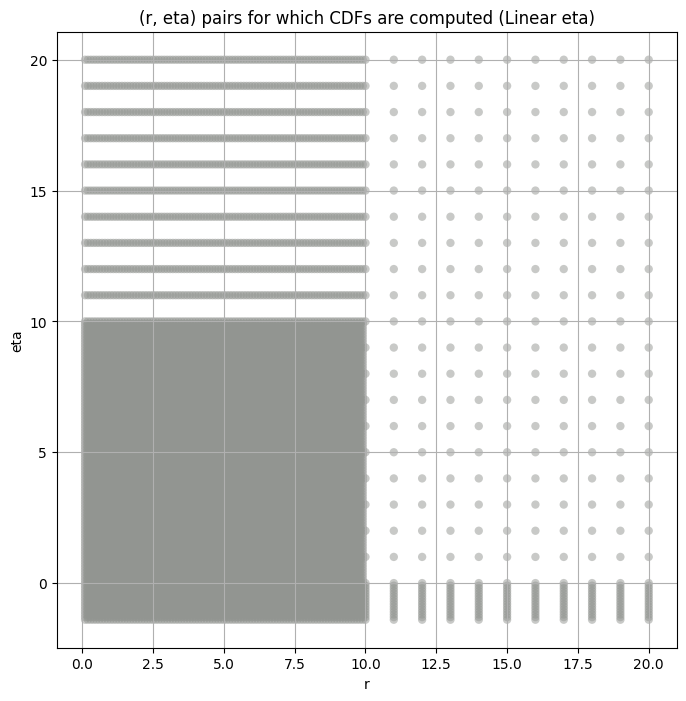

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:38<00:00, 2578.06it/s]


Layer 3


100%|██████████| 100000/100000 [00:40<00:00, 2449.92it/s]


Layer 4


100%|██████████| 100000/100000 [00:40<00:00, 2441.13it/s]


Layer 5


100%|██████████| 100000/100000 [00:41<00:00, 2413.99it/s]


Layer 6


100%|██████████| 100000/100000 [00:40<00:00, 2444.73it/s]


Layer 7


100%|██████████| 100000/100000 [00:41<00:00, 2433.63it/s]


Layer 8


100%|██████████| 100000/100000 [00:40<00:00, 2439.99it/s]


Layer 9


100%|██████████| 100000/100000 [00:40<00:00, 2442.52it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,17165.852000,16108.495000,18292.553000,4.017385,2.713827,6.006314,27208.0
3,4524.570000,4128.018600,4992.178700,11.562076,6.178833,24.957214,108832.0
4,1373.499500,1260.057300,1500.444800,9.261635,6.085780,16.255730,333298.0
5,373.972200,342.441220,410.995540,10.399797,6.170470,30.039886,1149538.0
6,90.558690,82.759690,99.775560,11.086198,6.617087,28.133839,4251250.0
7,20.864292,18.736567,23.678108,18.333368,9.082987,60.114044,17005000.0
8,4.537877,3.986680,5.319919,28.597765,12.662612,99.220190,68020000.0
9,0.850108,0.718232,1.177670,97.794940,14.378058,442.232270,272080000.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,17165.852000,17165.851562,16190.715820,15649.034180,15207.924805,14825.240234,14155.751953,13584.914062,13077.762695,12616.762695,12196.275391,11107.156250
3,4524.570000,4524.569824,4311.140625,4213.755859,4136.198730,4069.087646,3954.496338,3855.560791,3767.297607,3687.343506,3613.636475,3419.780762
4,1373.499500,1373.499512,1320.365112,1290.295898,1266.648926,1246.555786,1211.875000,1181.668579,1154.694458,1130.044800,1107.365845,1047.830200
5,373.972200,373.972198,359.376984,351.560913,345.128082,339.505585,329.764221,321.390900,313.948669,307.174438,300.903778,284.403870
6,90.558690,90.558693,86.808266,84.746513,83.079613,81.643227,79.187965,77.094597,75.238022,73.558784,72.015953,67.980103
7,20.864292,20.864292,19.725536,19.150278,18.691189,18.298927,17.635912,17.076574,16.586458,16.146557,15.745719,14.711512
8,4.537877,4.537877,4.217907,4.061454,3.939362,3.836597,3.666100,3.525177,3.403576,3.295851,3.198789,2.952856
9,0.850108,0.850108,0.758329,0.726251,0.702008,0.681956,0.649262,0.622683,0.600035,0.580169,0.562399,0.517890


####
Layer  2


100%|██████████| 12760/12760 [00:09<00:00, 1276.90it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.011857825622443918 17165.852


100%|██████████| 12760/12760 [00:09<00:00, 1308.04it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.011947084220978121 16190.716


100%|██████████| 12760/12760 [00:09<00:00, 1307.87it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.01258792466516745 15649.034


100%|██████████| 12760/12760 [00:09<00:00, 1304.36it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.014642685478956863 15207.925


100%|██████████| 12760/12760 [00:09<00:00, 1308.85it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.01580287643443623 14825.24


100%|██████████| 12760/12760 [00:09<00:00, 1307.69it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.016080600934448075 14155.752


100%|██████████| 12760/12760 [00:09<00:00, 1307.51it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.016215462048003615 13584.914


100%|██████████| 12760/12760 [00:09<00:00, 1306.18it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.016379575878652963 13077.763


100%|██████████| 12760/12760 [00:09<00:00, 1306.75it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.01749586416115645 12616.763


100%|██████████| 12760/12760 [00:09<00:00, 1307.98it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.02036110715328232 12196.275


100%|██████████| 12760/12760 [00:09<00:00, 1304.59it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.025296449674430677 11107.156
Number of samples: 27208, Without approximation : 27208.0


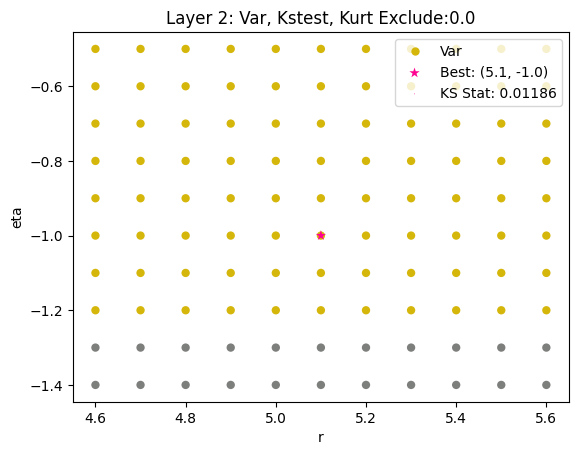

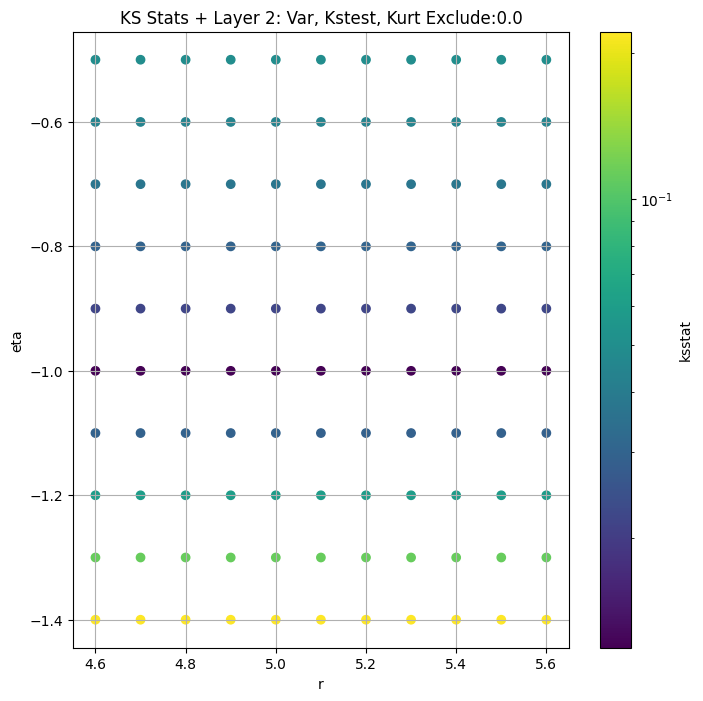

####
Layer  3


100%|██████████| 12760/12760 [00:34<00:00, 364.66it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.13152999999999976 4524.57


100%|██████████| 12760/12760 [00:35<00:00, 363.54it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.13152999999999976 4311.1406


100%|██████████| 12760/12760 [00:35<00:00, 356.80it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.13152999999999976 4213.756


100%|██████████| 12760/12760 [00:35<00:00, 357.15it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.13152999999999976 4136.1987


100%|██████████| 12760/12760 [00:35<00:00, 356.36it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.13152999999999976 4069.0876


100%|██████████| 12760/12760 [00:34<00:00, 366.96it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.13152999999999976 3954.4963


100%|██████████| 12760/12760 [00:34<00:00, 367.79it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.13152999999999976 3855.5608


100%|██████████| 12760/12760 [00:34<00:00, 366.45it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.13152999999999976 3767.2976


100%|██████████| 12760/12760 [00:34<00:00, 365.19it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.13152999999999976 3687.3435


100%|██████████| 12760/12760 [00:35<00:00, 358.04it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.13152999999999976 3613.6365


100%|██████████| 12760/12760 [00:35<00:00, 361.54it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.13152999999999976 3419.7808
Number of samples: 100000, Without approximation : 108832.0


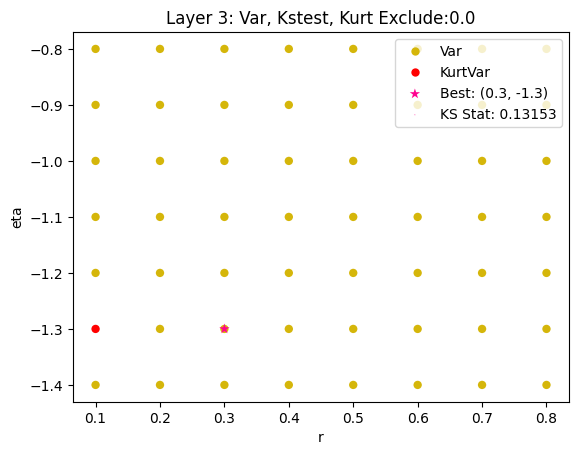

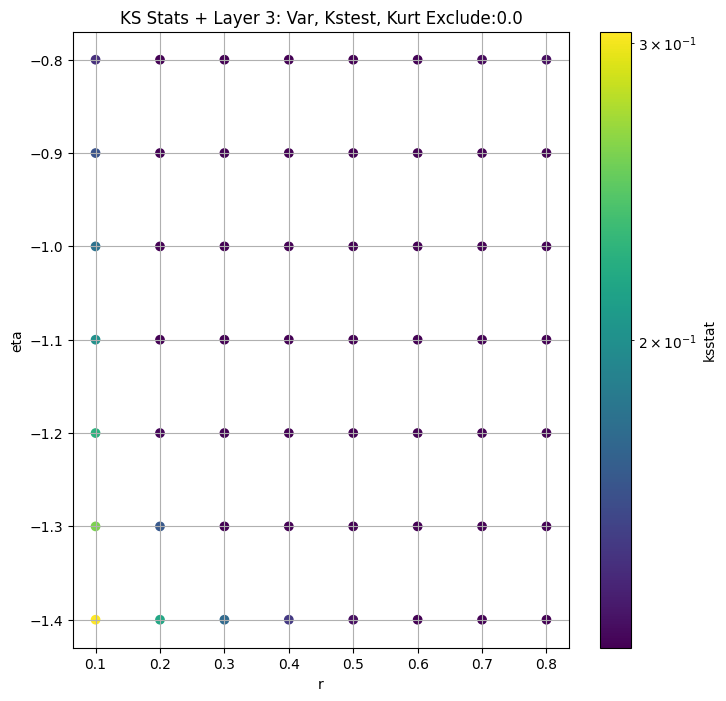

####
Layer  4


100%|██████████| 12760/12760 [00:35<00:00, 359.47it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.07635999999999987 1373.4995


100%|██████████| 12760/12760 [00:34<00:00, 364.67it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.07635999999999987 1320.3651


100%|██████████| 12760/12760 [00:34<00:00, 367.92it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.07635999999999987 1290.2959


100%|██████████| 12760/12760 [00:34<00:00, 367.94it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.07635999999999987 1266.6489


100%|██████████| 12760/12760 [00:34<00:00, 367.10it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.07635999999999987 1246.5558


100%|██████████| 12760/12760 [00:34<00:00, 367.09it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.07635999999999987 1211.875


100%|██████████| 12760/12760 [00:34<00:00, 367.88it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.07635999999999987 1181.6686


100%|██████████| 12760/12760 [00:34<00:00, 367.98it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.07635999999999987 1154.6945


100%|██████████| 12760/12760 [00:34<00:00, 367.25it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.07635999999999987 1130.0448


100%|██████████| 12760/12760 [00:34<00:00, 367.76it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.07635999999999987 1107.3658


100%|██████████| 12760/12760 [00:34<00:00, 367.65it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.07635999999999987 1047.8302
Number of samples: 100000, Without approximation : 333298.0


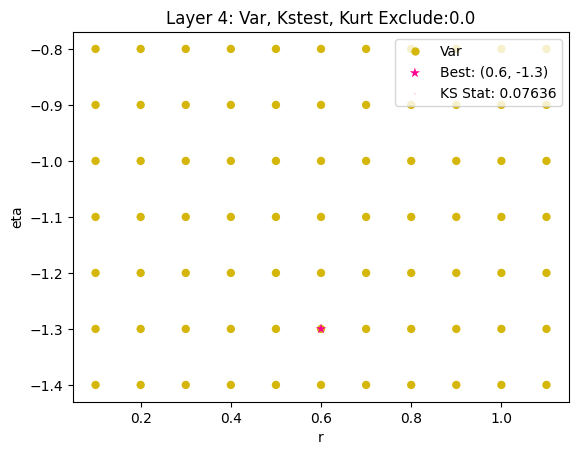

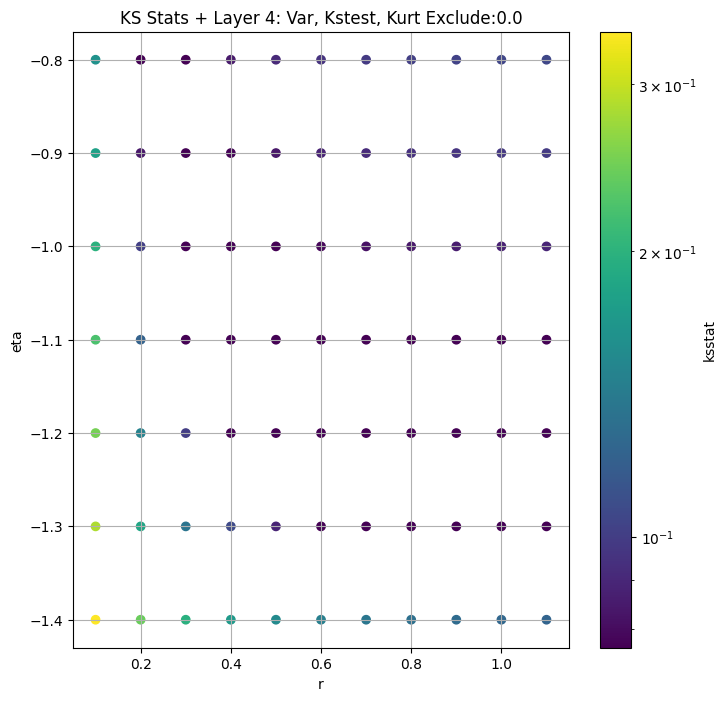

####
Layer  5


100%|██████████| 12760/12760 [00:34<00:00, 367.78it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.04019253422327007 373.9722


100%|██████████| 12760/12760 [00:34<00:00, 367.18it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.04019225902464452 359.37698


100%|██████████| 12760/12760 [00:34<00:00, 367.84it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.040192189618592 351.5609


100%|██████████| 12760/12760 [00:35<00:00, 364.21it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.040192312430455346 345.12808


100%|██████████| 12760/12760 [00:34<00:00, 365.88it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.040192084108517545 339.50558


100%|██████████| 12760/12760 [00:34<00:00, 366.68it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.0401920866827436 329.76422


100%|██████████| 12760/12760 [00:34<00:00, 364.57it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.04019201040902187 321.3909


100%|██████████| 12760/12760 [00:34<00:00, 364.70it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.04019194041910035 313.94867


100%|██████████| 12760/12760 [00:34<00:00, 367.64it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.040191873946796075 307.17444


100%|██████████| 12760/12760 [00:35<00:00, 364.37it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.04019177670222268 300.90378


100%|██████████| 12760/12760 [00:34<00:00, 367.68it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.04024510108016499 284.40387
Number of samples: 100000, Without approximation : 1149538.0


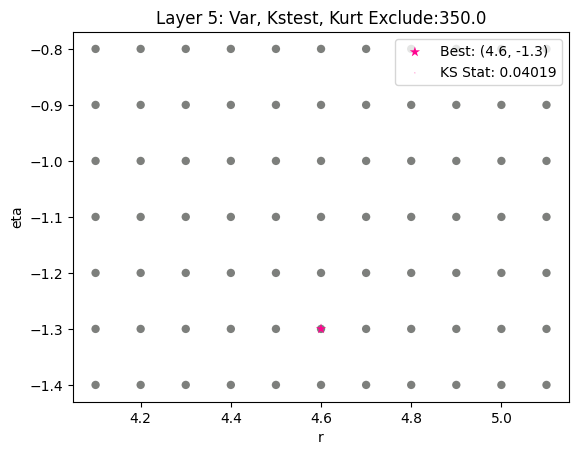

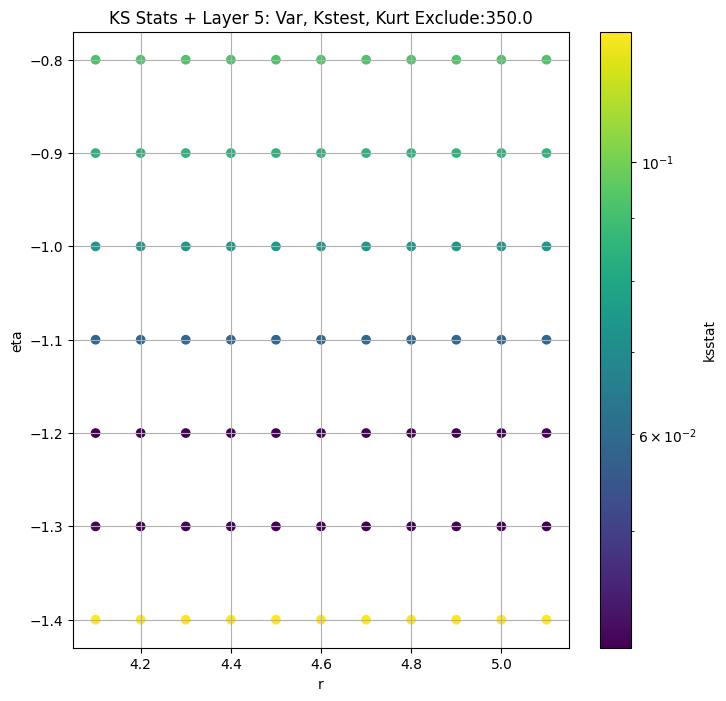

####
Layer  6


100%|██████████| 12760/12760 [00:34<00:00, 366.61it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.011267145212099205 90.55869


100%|██████████| 12760/12760 [00:34<00:00, 367.71it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.011004454497956617 86.808266


100%|██████████| 12760/12760 [00:34<00:00, 367.87it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.011027087670549551 84.74651


100%|██████████| 12760/12760 [00:34<00:00, 367.38it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.011071627838508569 83.07961


100%|██████████| 12760/12760 [00:34<00:00, 367.24it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.010970860963625206 81.64323


100%|██████████| 12760/12760 [00:34<00:00, 367.76it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.010994678944396763 79.187965


100%|██████████| 12760/12760 [00:34<00:00, 367.84it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.010969222216543006 77.0946


100%|██████████| 12760/12760 [00:34<00:00, 366.55it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.010951350217104416 75.23802


100%|██████████| 12760/12760 [00:34<00:00, 367.40it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.010946225830295808 73.558784


100%|██████████| 12760/12760 [00:34<00:00, 367.84it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.010945036650711726 72.01595


100%|██████████| 12760/12760 [00:34<00:00, 367.37it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.011158485764974913 67.9801
Number of samples: 100000, Without approximation : 4251250.0


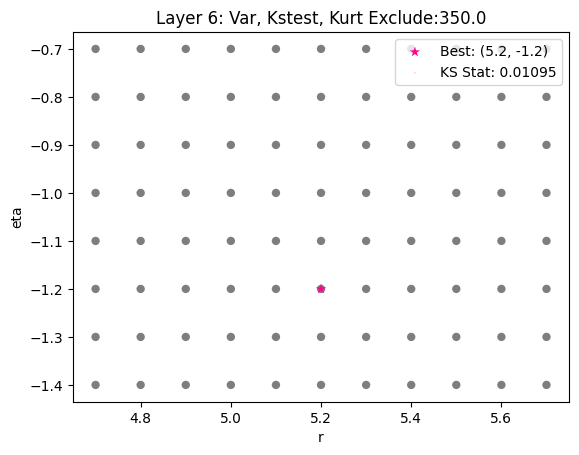

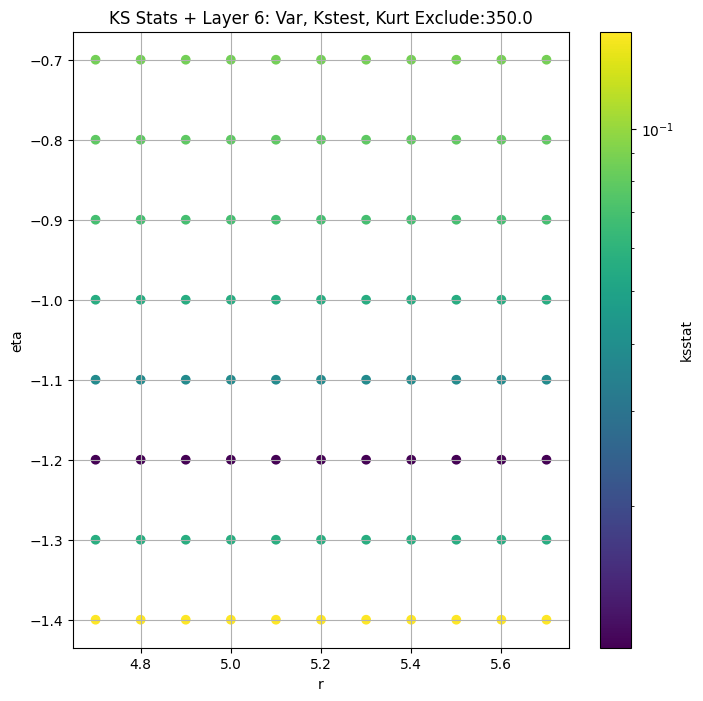

####
Layer  7


100%|██████████| 12760/12760 [00:34<00:00, 367.67it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.015040656749489456 20.864292


100%|██████████| 12760/12760 [00:34<00:00, 364.94it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.015035004579848243 19.725536


100%|██████████| 12760/12760 [00:34<00:00, 367.23it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.01498792464098364 19.150278


100%|██████████| 12760/12760 [00:35<00:00, 360.05it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.015118307068910541 18.691189


100%|██████████| 12760/12760 [00:34<00:00, 367.20it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.014960598161949001 18.298927


100%|██████████| 12760/12760 [00:34<00:00, 367.66it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.015013766365270076 17.635912


100%|██████████| 12760/12760 [00:34<00:00, 366.76it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.014963054191591274 17.076574


100%|██████████| 12760/12760 [00:34<00:00, 366.42it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.01491697216939808 16.586458


100%|██████████| 12760/12760 [00:35<00:00, 362.43it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.01486383203546865 16.146557


100%|██████████| 12760/12760 [00:34<00:00, 367.74it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.014857843021424233 15.745719


100%|██████████| 12760/12760 [00:38<00:00, 328.61it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.014830681305867954 14.711512
Number of samples: 100000, Without approximation : 17005000.0


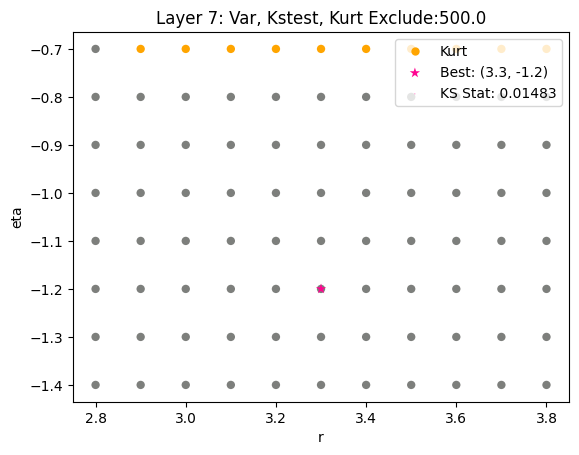

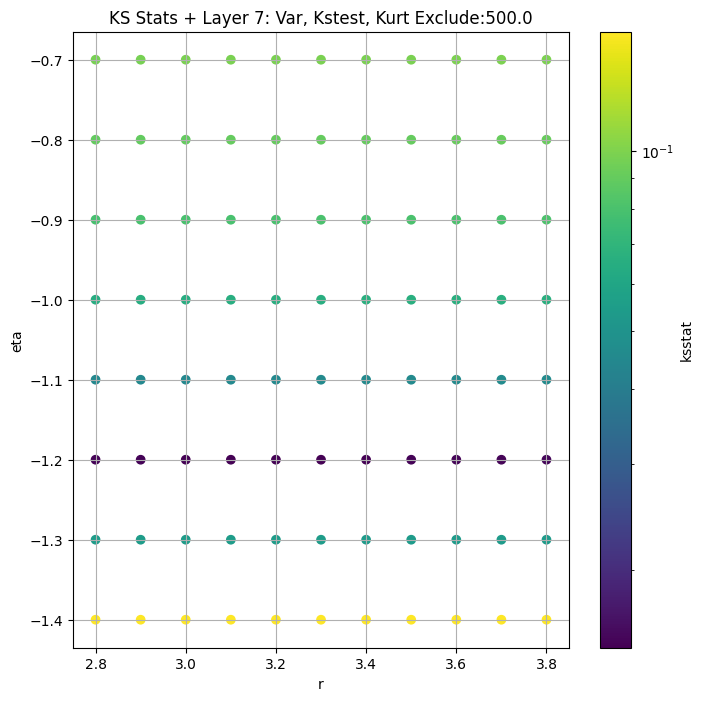

####
Layer  8


100%|██████████| 12760/12760 [00:35<00:00, 356.00it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.013255537861626143 4.537877


100%|██████████| 12760/12760 [00:34<00:00, 367.40it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.013255371706446972 4.217907


100%|██████████| 12760/12760 [00:34<00:00, 365.62it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.013254688450425212 4.061454


100%|██████████| 12760/12760 [00:35<00:00, 364.35it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.013560657160304634 3.9393616


100%|██████████| 12760/12760 [00:34<00:00, 368.01it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.013970568331991284 3.836597


100%|██████████| 12760/12760 [00:34<00:00, 367.57it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.01468416176761883 3.6661003


100%|██████████| 12760/12760 [00:34<00:00, 367.09it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.014913670488472447 3.525177


100%|██████████| 12760/12760 [00:34<00:00, 367.10it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.015912363132555674 3.4035757


100%|██████████| 12760/12760 [00:34<00:00, 367.90it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.01716975388745 3.2958508


100%|██████████| 12760/12760 [00:34<00:00, 367.46it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.01772850730608977 3.1987891


100%|██████████| 12760/12760 [00:34<00:00, 367.53it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.014634939356277021 2.9528563
Number of samples: 100000, Without approximation : 68020000.0


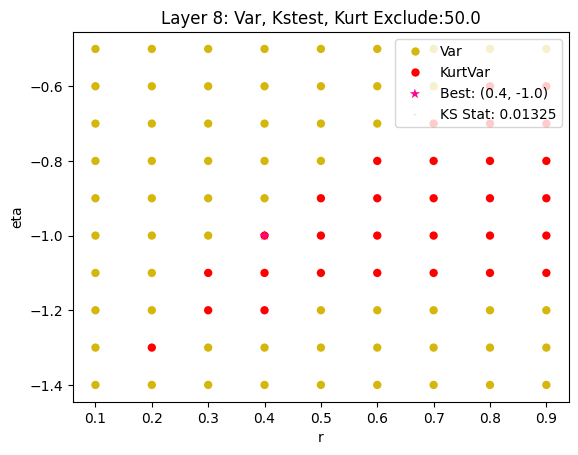

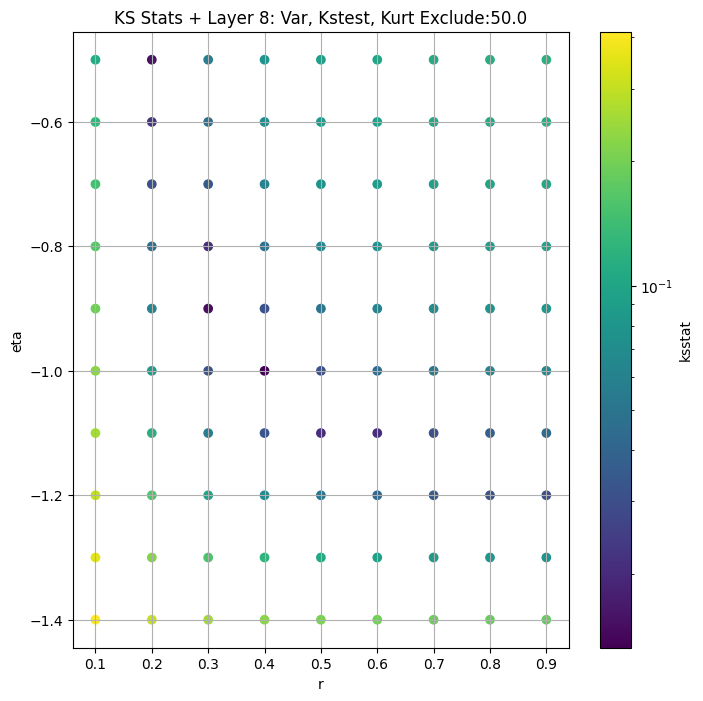

####
Layer  9


100%|██████████| 12760/12760 [00:34<00:00, 367.78it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.024493839339562284 0.850108


100%|██████████| 12760/12760 [00:34<00:00, 367.37it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.02449642840070476 0.7583287


100%|██████████| 12760/12760 [00:34<00:00, 367.77it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.024494432471502736 0.72625077


100%|██████████| 12760/12760 [00:34<00:00, 366.98it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.02449433715253657 0.70200753


100%|██████████| 12760/12760 [00:34<00:00, 367.75it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.02449425450163023 0.6819556


100%|██████████| 12760/12760 [00:34<00:00, 367.40it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.0244941116191848 0.6492616


100%|██████████| 12760/12760 [00:34<00:00, 367.75it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.024494684350036766 0.6226825


100%|██████████| 12760/12760 [00:34<00:00, 367.76it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.02449458496240209 0.60003483


100%|██████████| 12760/12760 [00:34<00:00, 367.16it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.024494343002776198 0.5801691


100%|██████████| 12760/12760 [00:34<00:00, 367.81it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.024494254325872156 0.56239897


100%|██████████| 12760/12760 [00:34<00:00, 365.53it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.024491902440839874 0.51789045
Number of samples: 100000, Without approximation : 272080000.0


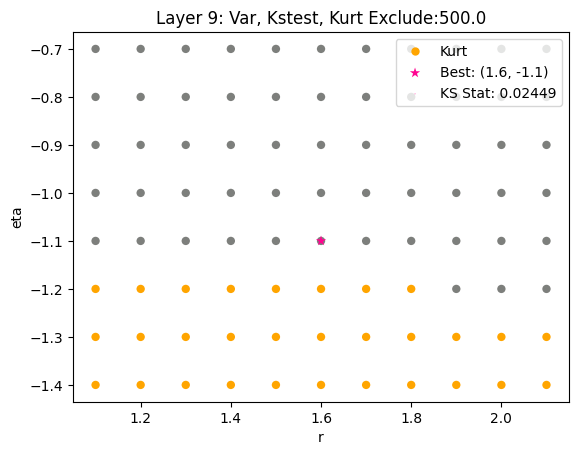

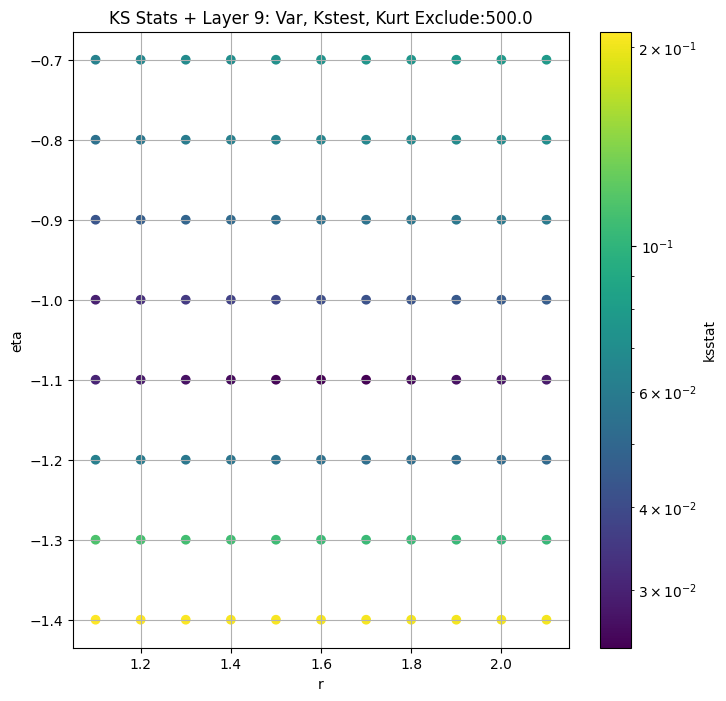

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,17165.852000,16108.495000,18292.553000,4.017385,2.713827,6.006314,27208.0,0.011858,5.1,-1.0,54579.340804,0.0,17165.852000,0.008227
3,4524.570000,4128.018600,4992.178700,11.562076,6.178833,24.957214,108832.0,0.131530,0.3,-1.3,1021.133528,0.0,4524.570000,0.004115
4,1373.499500,1260.057300,1500.444800,9.261635,6.085780,16.255730,333298.0,0.076360,0.6,-1.3,3679.520769,0.0,1373.499500,0.002352
5,373.972200,342.441220,410.995540,10.399797,6.170470,30.039886,1149538.0,0.040192,4.6,-1.3,1950.127719,350.0,300.903780,0.001267
6,90.558690,82.759690,99.775560,11.086198,6.617087,28.133839,4251250.0,0.010945,5.2,-1.2,333.905860,350.0,72.015950,0.000659
7,20.864292,18.736567,23.678108,18.333368,9.082987,60.114044,17005000.0,0.014831,3.3,-1.2,68.595622,500.0,14.711512,0.000329
8,4.537877,3.986680,5.319919,28.597765,12.662612,99.220190,68020000.0,0.013255,0.4,-1.0,0.832313,50.0,4.061454,0.000165
9,0.850108,0.718232,1.177670,97.794940,14.378058,442.232270,272080000.0,0.024492,1.6,-1.1,1.723181,500.0,0.517890,0.000082


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 167/167 [00:00<00:00, 1252.04it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.013477529408765843, var: 14825.240234375


100%|██████████| 167/167 [00:00<00:00, 1260.49it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.012936983865540319, var: 15207.9248046875


100%|██████████| 167/167 [00:00<00:00, 1281.65it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.012407887462193679, var: 15649.0341796875


100%|██████████| 167/167 [00:00<00:00, 1280.09it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.01192892895498332, var: 16190.7158203125


100%|██████████| 167/167 [00:00<00:00, 1083.61it/s]


Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.011857825622443918, var: 17165.8515625
Number of samples: 27208, Without approximation : 27208.0


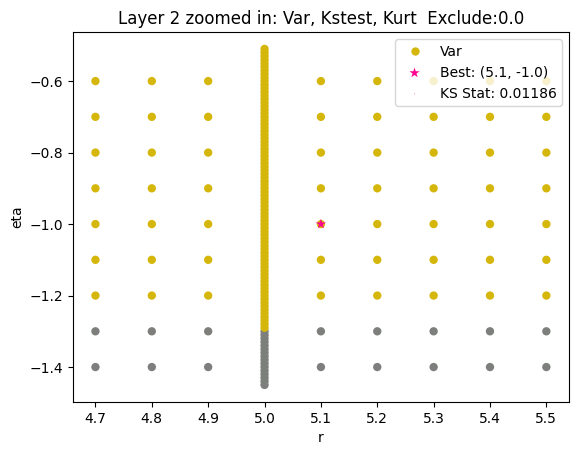

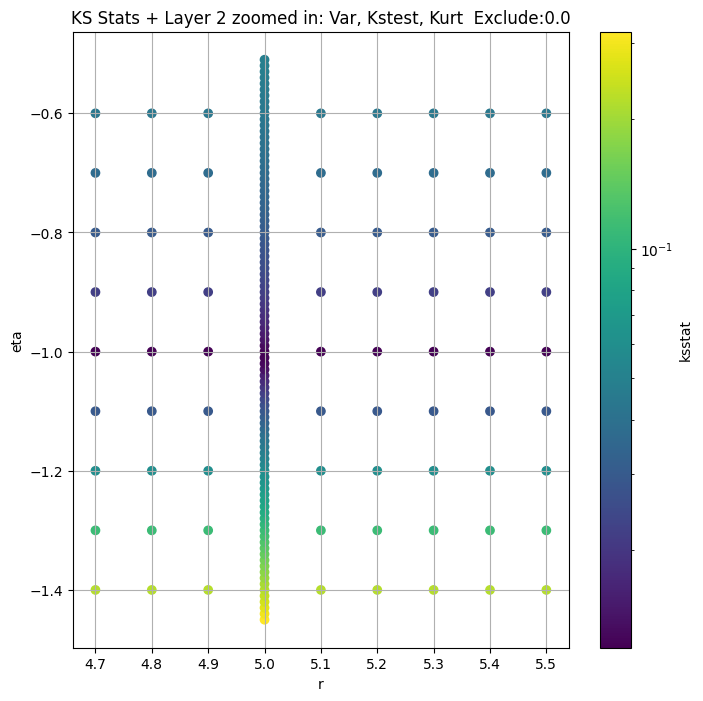

Layer 3


100%|██████████| 881/881 [00:02<00:00, 361.25it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.13152999999999976, var: 4069.087646484375


100%|██████████| 881/881 [00:02<00:00, 364.72it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.13152999999999976, var: 4136.19873046875


100%|██████████| 881/881 [00:02<00:00, 366.08it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.13152999999999976, var: 4213.755859375


100%|██████████| 881/881 [00:02<00:00, 364.90it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.13152999999999976, var: 4311.140625


100%|██████████| 881/881 [00:02<00:00, 366.29it/s]


Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.13152999999999976, var: 4524.56982421875
Number of samples: 100000, Without approximation : 108832.0


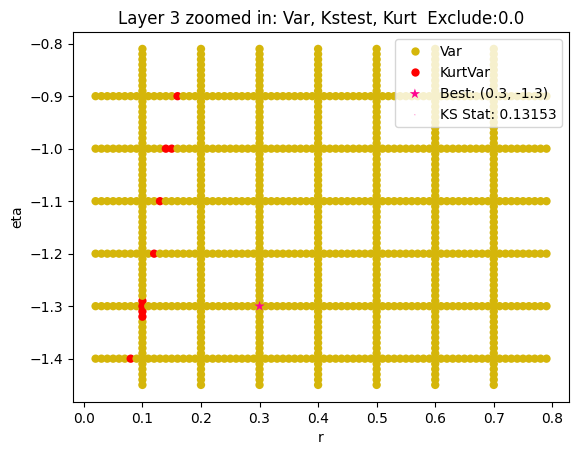

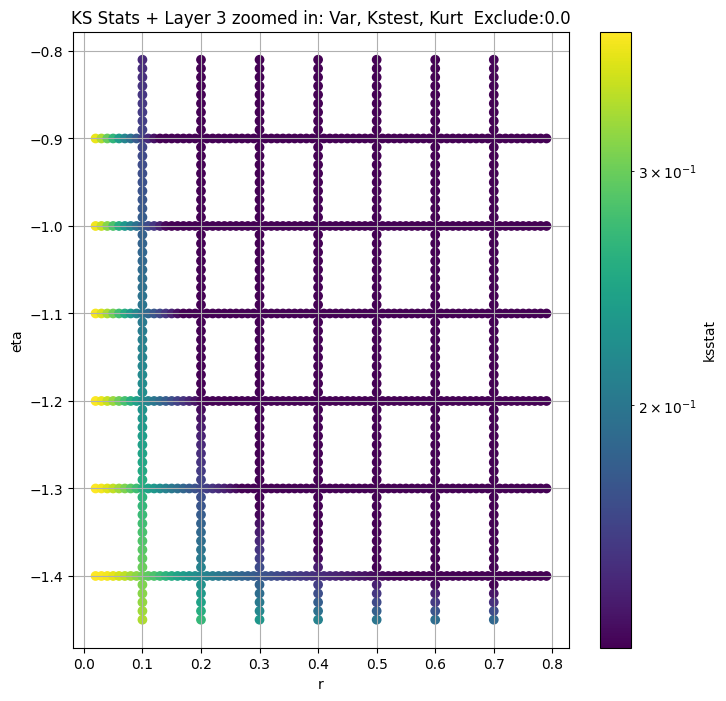

Layer 4


100%|██████████| 1125/1125 [00:03<00:00, 362.81it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.07635999999999987, var: 1246.5557861328125


100%|██████████| 1125/1125 [00:03<00:00, 364.77it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.07635999999999987, var: 1266.64892578125


100%|██████████| 1125/1125 [00:03<00:00, 365.64it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.07635999999999987, var: 1290.2958984375


100%|██████████| 1125/1125 [00:03<00:00, 362.46it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.07635999999999987, var: 1320.3651123046875


100%|██████████| 1125/1125 [00:03<00:00, 364.98it/s]


Finding Minimum after computing 1125 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.07635999999999987, var: 1373.49951171875
Number of samples: 100000, Without approximation : 333298.0


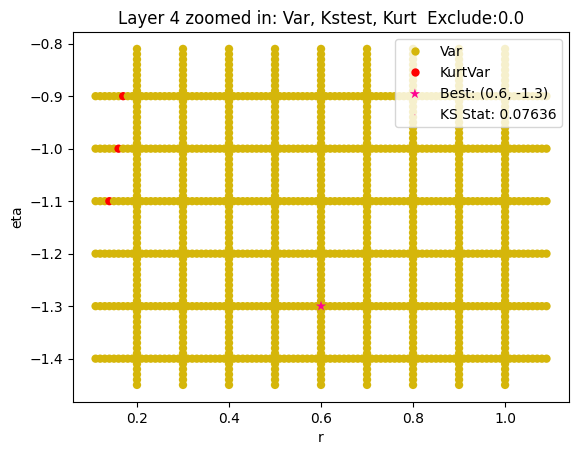

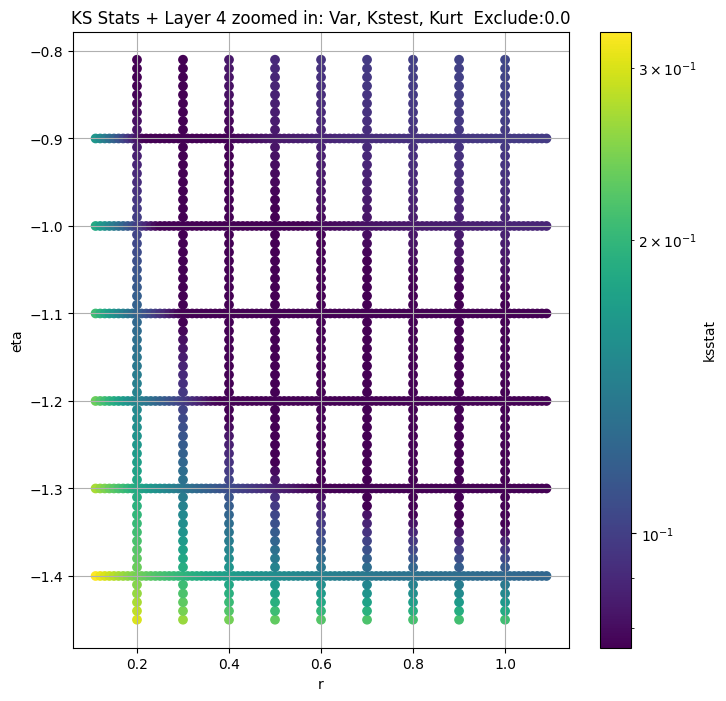

Layer 5


100%|██████████| 113/113 [00:00<00:00, 348.74it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.04021653852101287, var: 289.574951171875


100%|██████████| 113/113 [00:00<00:00, 365.78it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.04021664715693518, var: 292.275390625


100%|██████████| 113/113 [00:00<00:00, 363.89it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.040216757645782863, var: 295.0608215332031


100%|██████████| 113/113 [00:00<00:00, 365.11it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.04021687003495267, var: 297.9352111816406


100%|██████████| 113/113 [00:00<00:00, 365.98it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.04019177670222268, var: 300.9037780761719


100%|██████████| 113/113 [00:00<00:00, 365.21it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.040191850591033584, var: 303.9804382324219


100%|██████████| 113/113 [00:00<00:00, 363.07it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.0401919973213673, var: 307.1744384765625


100%|██████████| 113/113 [00:00<00:00, 365.60it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.04019214732880072, var: 310.4920959472656


100%|██████████| 113/113 [00:00<00:00, 365.61it/s]


Finding Minimum after computing 113 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.04019230108116162, var: 313.94866943359375
Number of samples: 100000, Without approximation : 1149538.0


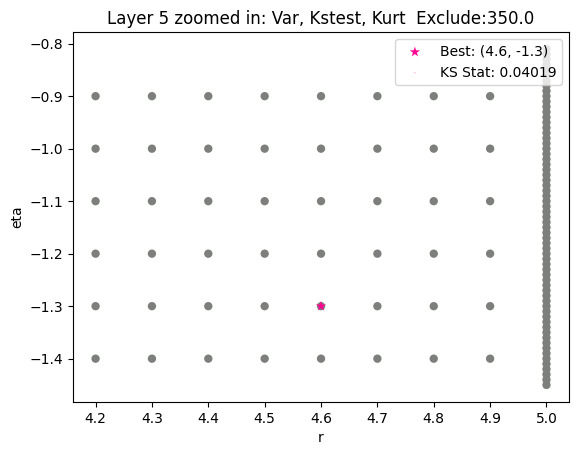

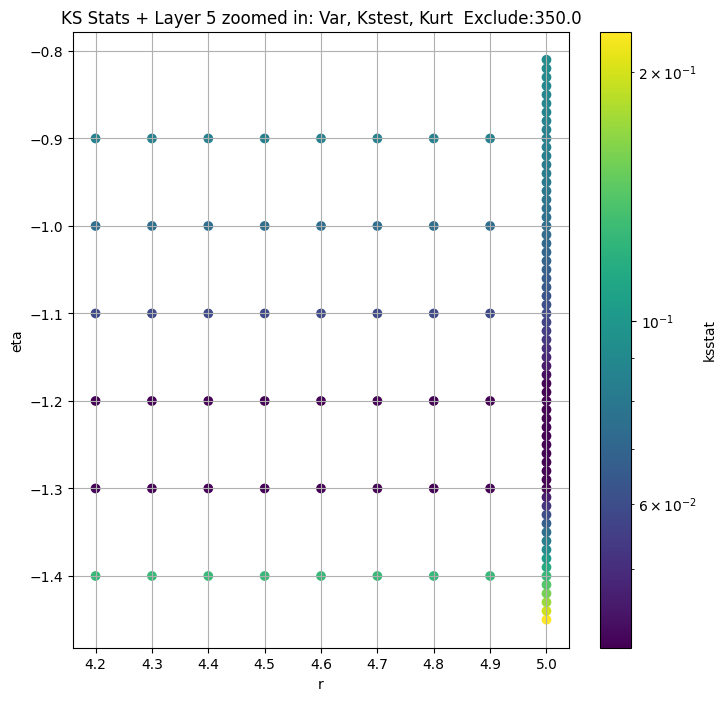

Layer 6


100%|██████████| 131/131 [00:00<00:00, 365.40it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + 100 = 450, ksstat: 0.011166477757133808, var: 69.2406234741211


100%|██████████| 131/131 [00:00<00:00, 364.81it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + 75 = 425, ksstat: 0.011106052706015002, var: 69.90031433105469


100%|██████████| 131/131 [00:00<00:00, 365.74it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + 50 = 400, ksstat: 0.01104440398087092, var: 70.5817642211914


100%|██████████| 131/131 [00:00<00:00, 366.35it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + 25 = 375, ksstat: 0.010981430294640049, var: 71.28675842285156


100%|██████████| 131/131 [00:00<00:00, 363.70it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + 0 = 350, ksstat: 0.010945036650711726, var: 72.01595306396484


100%|██████████| 131/131 [00:00<00:00, 361.40it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + -25 = 325, ksstat: 0.011055243516660207, var: 72.77224731445312


100%|██████████| 131/131 [00:00<00:00, 366.33it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + -50 = 300, ksstat: 0.011312075322477466, var: 73.55878448486328


100%|██████████| 131/131 [00:00<00:00, 366.37it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + -75 = 275, ksstat: 0.011576267395915885, var: 74.37899017333984


100%|██████████| 131/131 [00:00<00:00, 366.35it/s]


Finding Minimum after computing 131 CDFs
layer 6, 350.0 + -100 = 250, ksstat: 0.011849085943803073, var: 75.23802185058594
Number of samples: 100000, Without approximation : 4251250.0


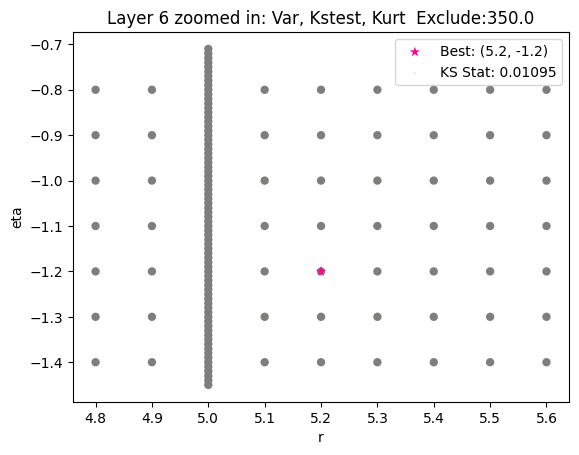

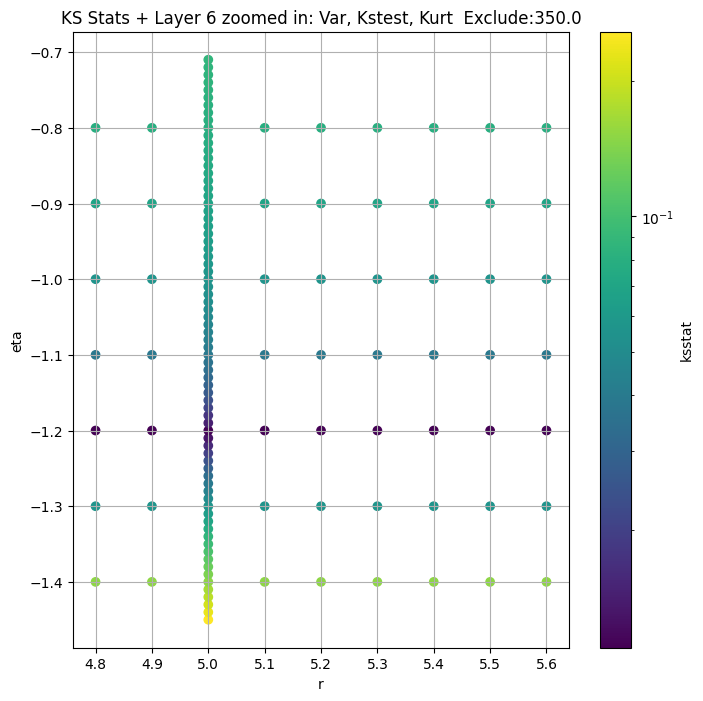

Layer 7


100%|██████████| 131/131 [00:00<00:00, 363.39it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + 100 = 600, ksstat: 0.015046689891612619, var: 14.123992919921875


100%|██████████| 131/131 [00:00<00:00, 366.67it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + 75 = 575, ksstat: 0.014964047032775263, var: 14.264725685119629


100%|██████████| 131/131 [00:00<00:00, 365.52it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + 50 = 550, ksstat: 0.014880171916241913, var: 14.40939712524414


100%|██████████| 131/131 [00:00<00:00, 357.61it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + 25 = 525, ksstat: 0.01482211627617891, var: 14.558239936828613


100%|██████████| 131/131 [00:00<00:00, 366.59it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + 0 = 500, ksstat: 0.014830681305867954, var: 14.711511611938477


100%|██████████| 131/131 [00:00<00:00, 366.11it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + -25 = 475, ksstat: 0.014835658076548741, var: 14.8695068359375


100%|██████████| 131/131 [00:00<00:00, 366.03it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + -50 = 450, ksstat: 0.014841820089448232, var: 15.032671928405762


100%|██████████| 131/131 [00:00<00:00, 366.30it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + -75 = 425, ksstat: 0.015176732730321163, var: 15.201417922973633


100%|██████████| 131/131 [00:00<00:00, 366.10it/s]


Finding Minimum after computing 131 CDFs
layer 7, 500.0 + -100 = 400, ksstat: 0.015522848810170742, var: 15.376152992248535
Number of samples: 100000, Without approximation : 17005000.0


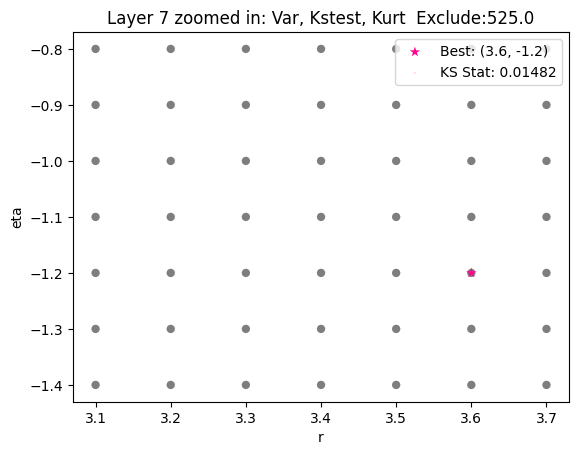

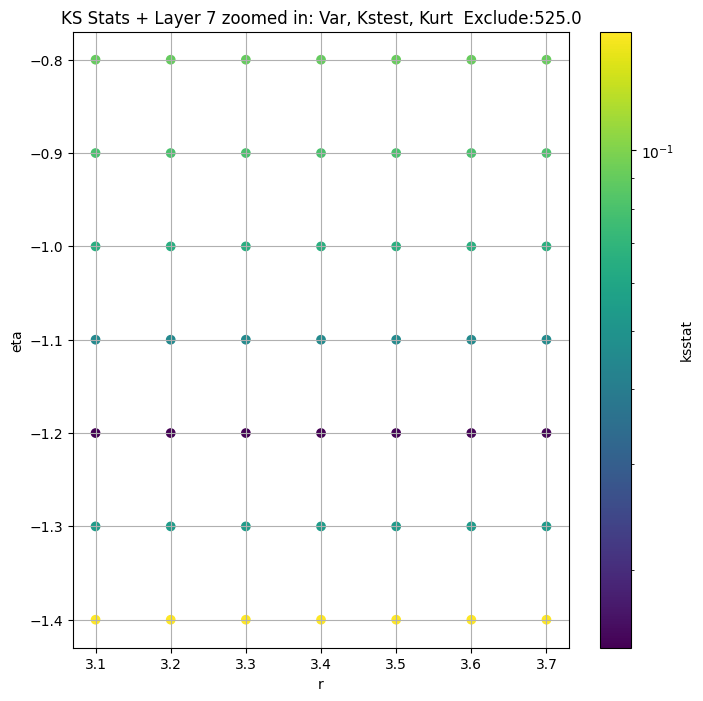

Layer 8


100%|██████████| 1480/1480 [00:04<00:00, 363.81it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.013254087995985042, var: 3.666100263595581


100%|██████████| 1480/1480 [00:04<00:00, 365.39it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.013254151888032806, var: 3.7466440200805664


100%|██████████| 1480/1480 [00:04<00:00, 365.31it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.013254023633473277, var: 3.836596965789795


100%|██████████| 1480/1480 [00:04<00:00, 365.69it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.013254102100083487, var: 3.939361572265625


100%|██████████| 1480/1480 [00:04<00:00, 365.59it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.013254688450425212, var: 4.061453819274902


100%|██████████| 1480/1480 [00:04<00:00, 365.45it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.013255371706446972, var: 4.217906951904297


100%|██████████| 1480/1480 [00:04<00:00, 366.21it/s]


Finding Minimum after computing 1480 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.013255296113990456, var: 4.537877082824707
Number of samples: 100000, Without approximation : 68020000.0


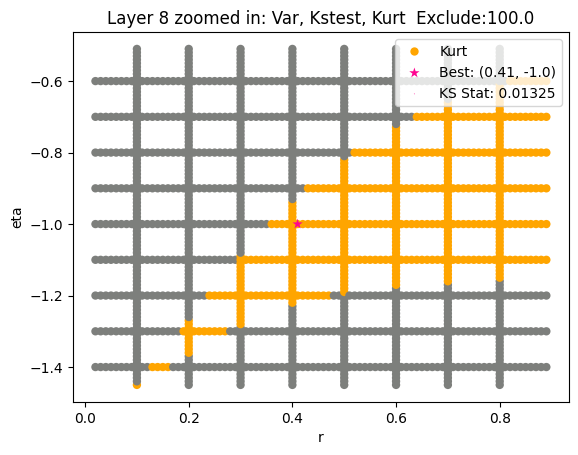

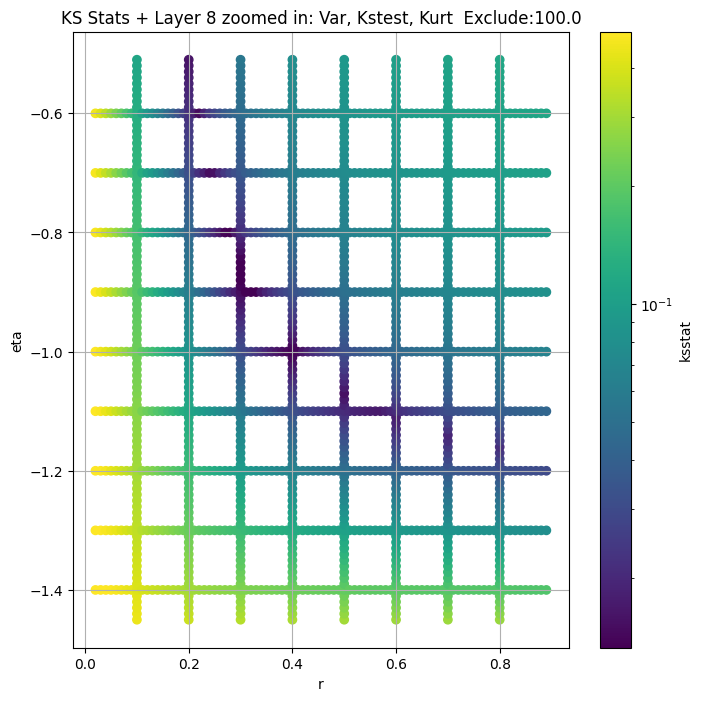

Layer 9


100%|██████████| 1413/1413 [00:03<00:00, 361.22it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + 100 = 600, ksstat: 0.024489614528447556, var: 0.4933585822582245


100%|██████████| 1413/1413 [00:03<00:00, 365.67it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + 75 = 575, ksstat: 0.024489604207080018, var: 0.4991886019706726


100%|██████████| 1413/1413 [00:03<00:00, 364.78it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + 50 = 550, ksstat: 0.024489601847339504, var: 0.5052105784416199


100%|██████████| 1413/1413 [00:03<00:00, 366.10it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + 25 = 525, ksstat: 0.024489610024095, var: 0.5114397406578064


100%|██████████| 1413/1413 [00:03<00:00, 362.48it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + 0 = 500, ksstat: 0.024489600828151104, var: 0.517890453338623


100%|██████████| 1413/1413 [00:03<00:00, 363.79it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + -25 = 475, ksstat: 0.024489603203908472, var: 0.5245789885520935


100%|██████████| 1413/1413 [00:03<00:00, 365.61it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + -50 = 450, ksstat: 0.02448960279437362, var: 0.531526505947113


100%|██████████| 1413/1413 [00:03<00:00, 365.46it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + -75 = 425, ksstat: 0.024489599295819064, var: 0.5387541055679321


100%|██████████| 1413/1413 [00:03<00:00, 366.21it/s]


Finding Minimum after computing 1413 CDFs
layer 9, 500.0 + -100 = 400, ksstat: 0.02448959239105364, var: 0.5462895631790161
Number of samples: 100000, Without approximation : 272080000.0


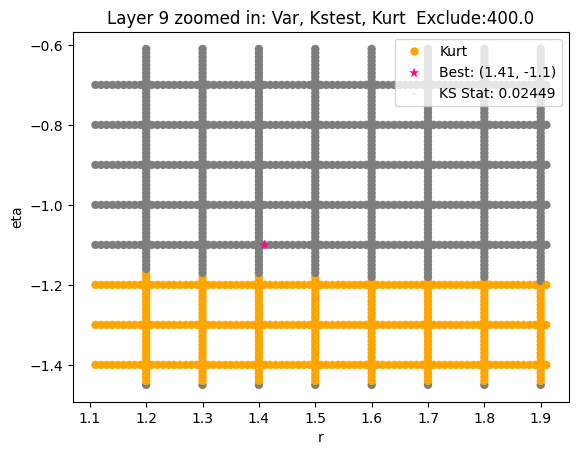

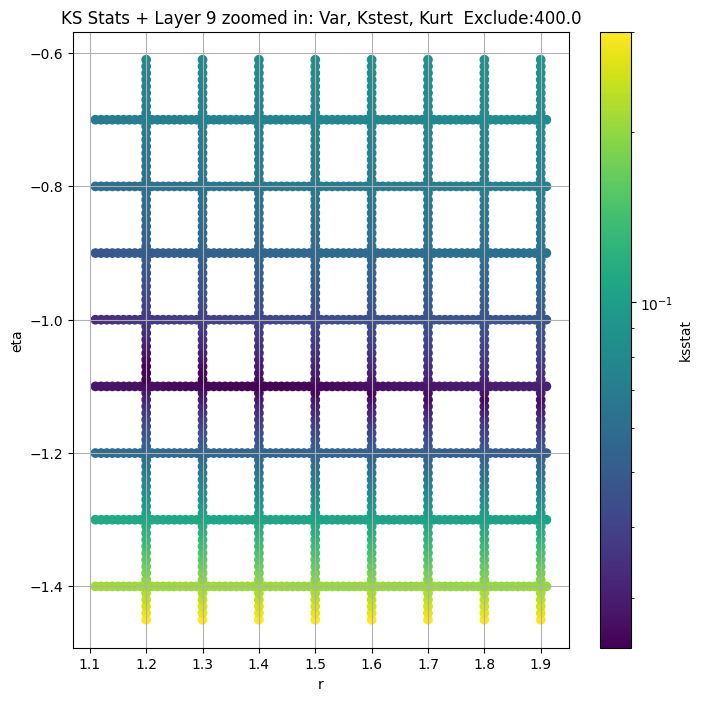

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,17165.852000,16108.495000,18292.553000,4.017385,2.713827,6.006314,27208.0,0.011858,5.1,-1.0,54579.340804,0.0,17165.852000,0.008227,0.011858,5.10,-1.0,54579.340804,0.0,13604
3,4524.570000,4128.018600,4992.178700,11.562076,6.178833,24.957214,108832.0,0.131530,0.3,-1.3,1021.133528,0.0,4524.570000,0.004115,0.131530,0.30,-1.3,1021.133528,0.0,106
4,1373.499500,1260.057300,1500.444800,9.261635,6.085780,16.255730,333298.0,0.076360,0.6,-1.3,3679.520769,0.0,1373.499500,0.002352,0.076360,0.60,-1.3,3679.520769,0.0,325
5,373.972200,342.441220,410.995540,10.399797,6.170470,30.039886,1149538.0,0.040192,4.6,-1.3,1950.127719,350.0,300.903780,0.001267,0.040192,4.60,-1.3,1950.127719,350.0,1122
6,90.558690,82.759690,99.775560,11.086198,6.617087,28.133839,4251250.0,0.010945,5.2,-1.2,333.905860,350.0,72.015950,0.000659,0.010945,5.20,-1.2,333.905860,350.0,15760
7,20.864292,18.736567,23.678108,18.333368,9.082987,60.114044,17005000.0,0.014831,3.3,-1.2,68.595622,500.0,14.558240,0.000329,0.014822,3.60,-1.2,67.919651,525.0,8303
8,4.537877,3.986680,5.319919,28.597765,12.662612,99.220190,68020000.0,0.013255,0.4,-1.0,0.832313,50.0,3.836597,0.000165,0.013254,0.41,-1.0,0.881496,100.0,10507
9,0.850108,0.718232,1.177670,97.794940,14.378058,442.232270,272080000.0,0.024492,1.6,-1.1,1.723181,500.0,0.546290,0.000082,0.024490,1.41,-1.1,1.726120,400.0,3112


In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

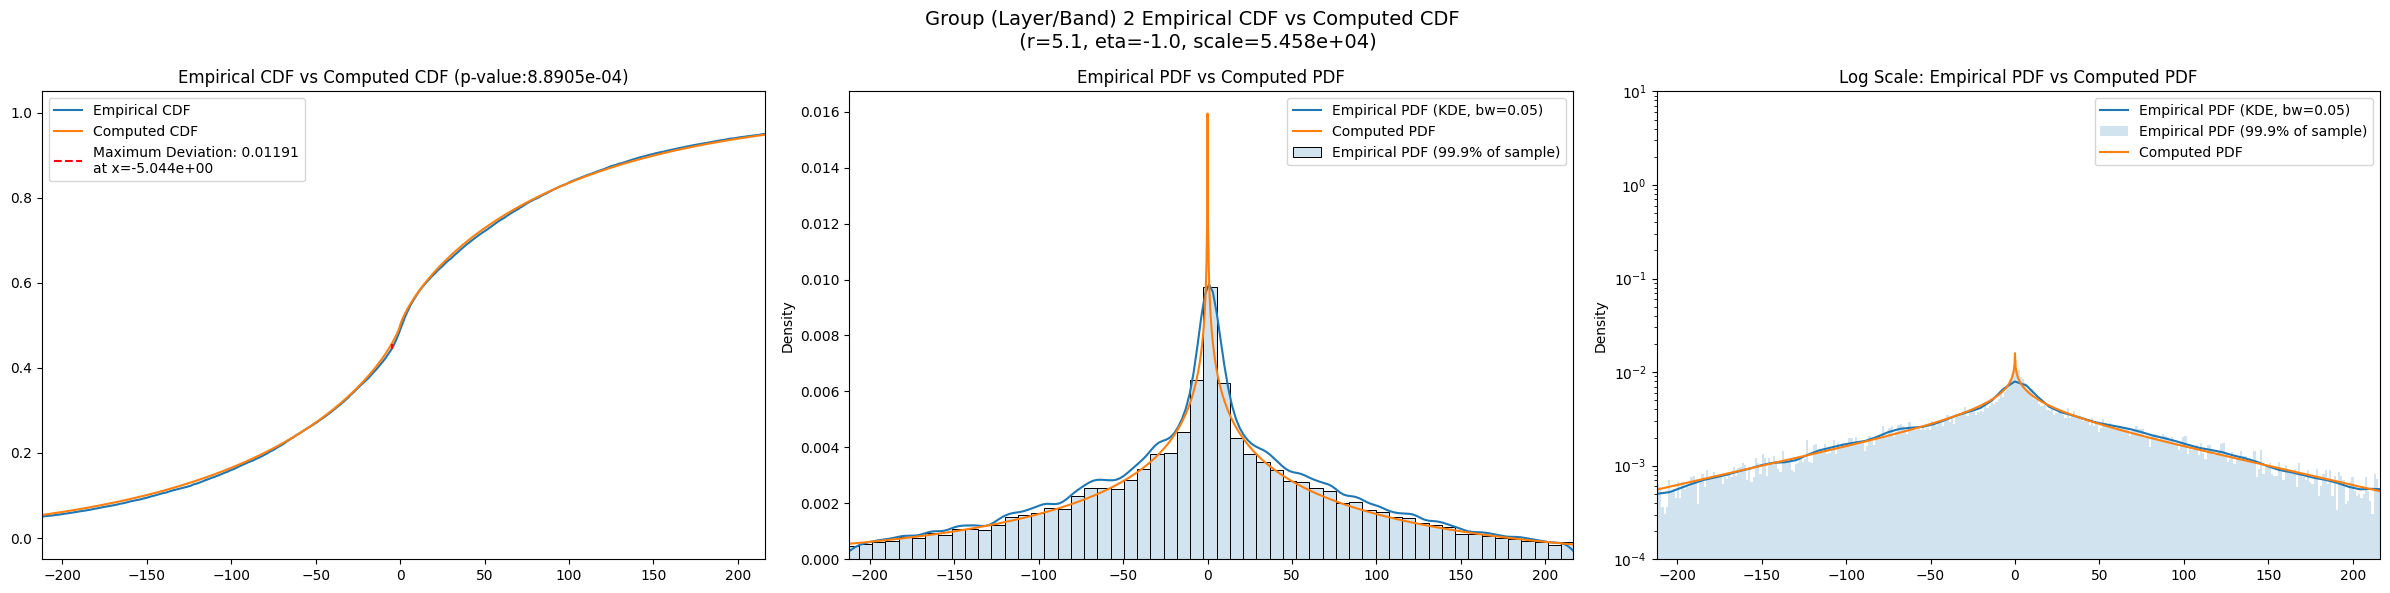

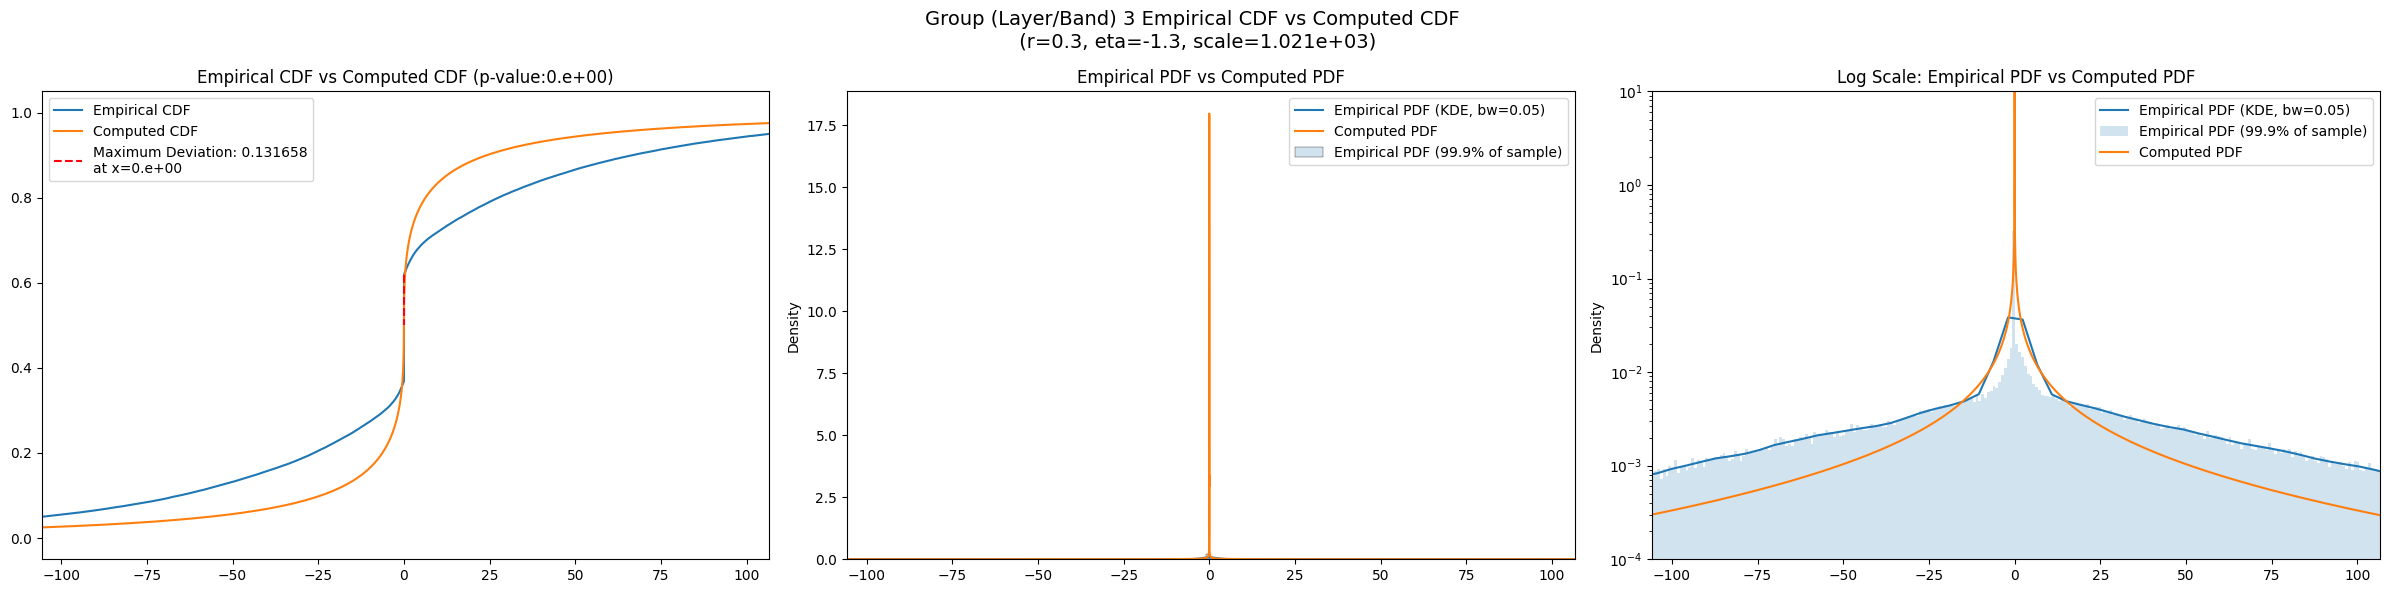

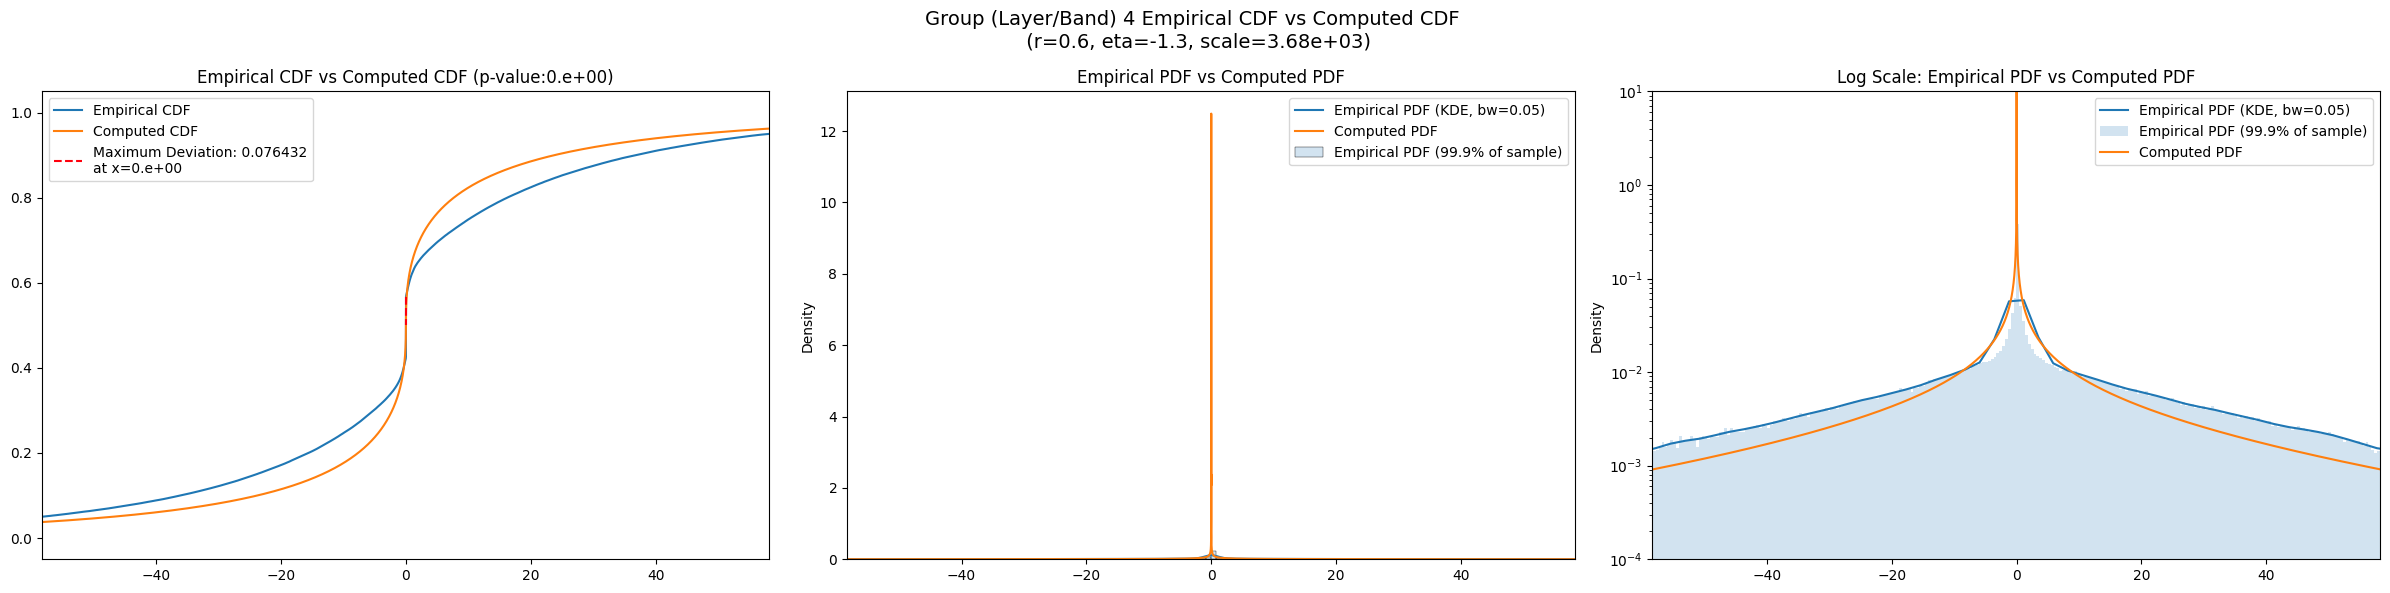

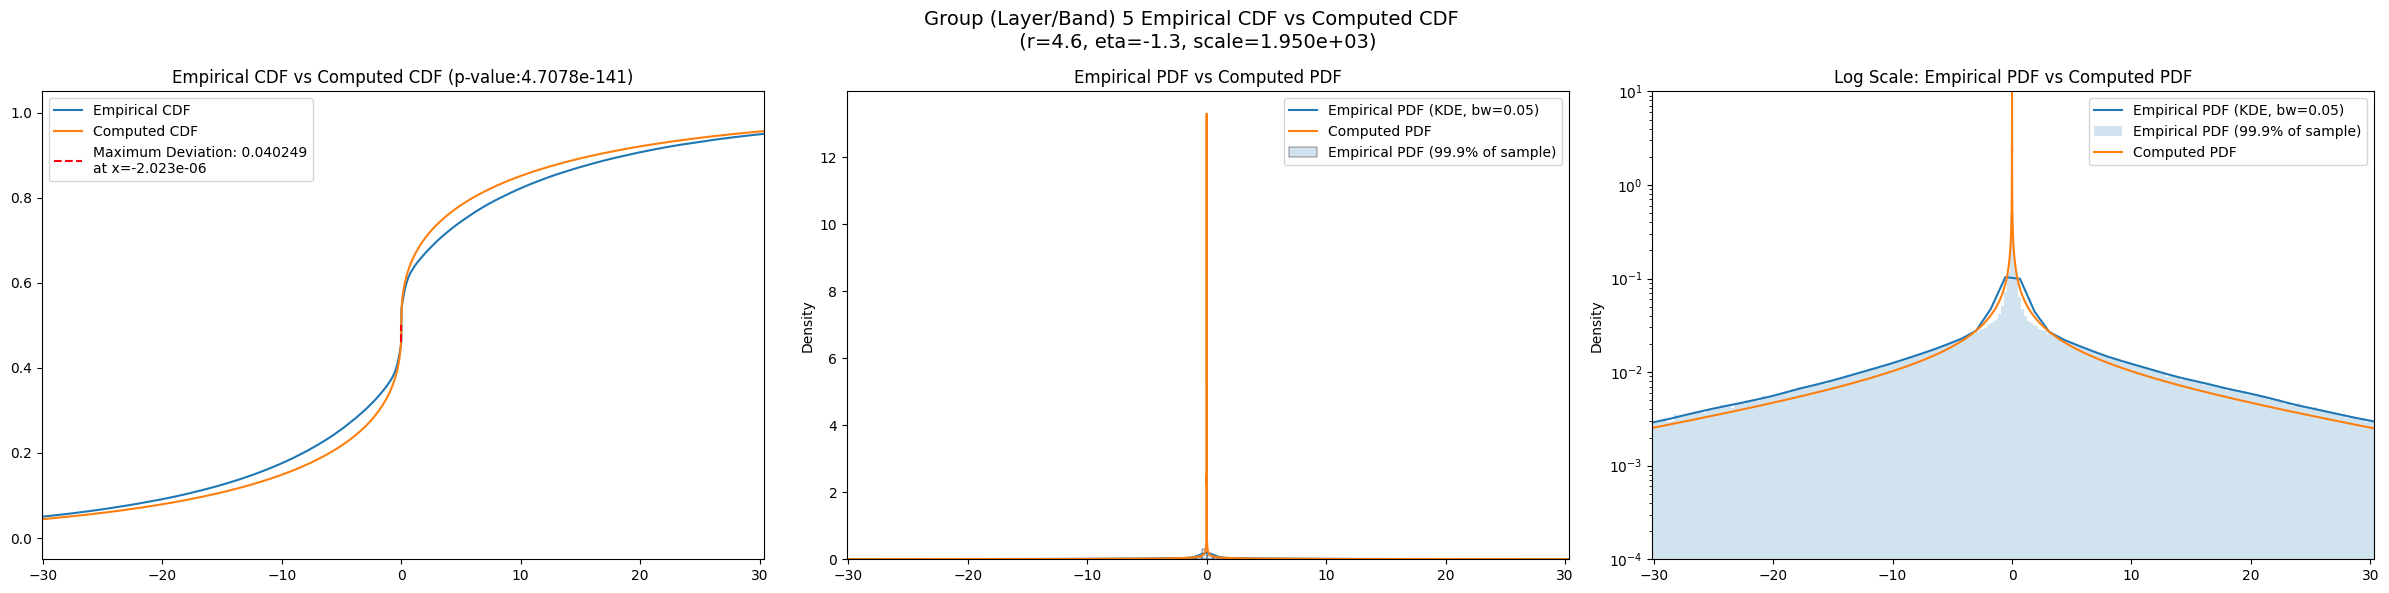

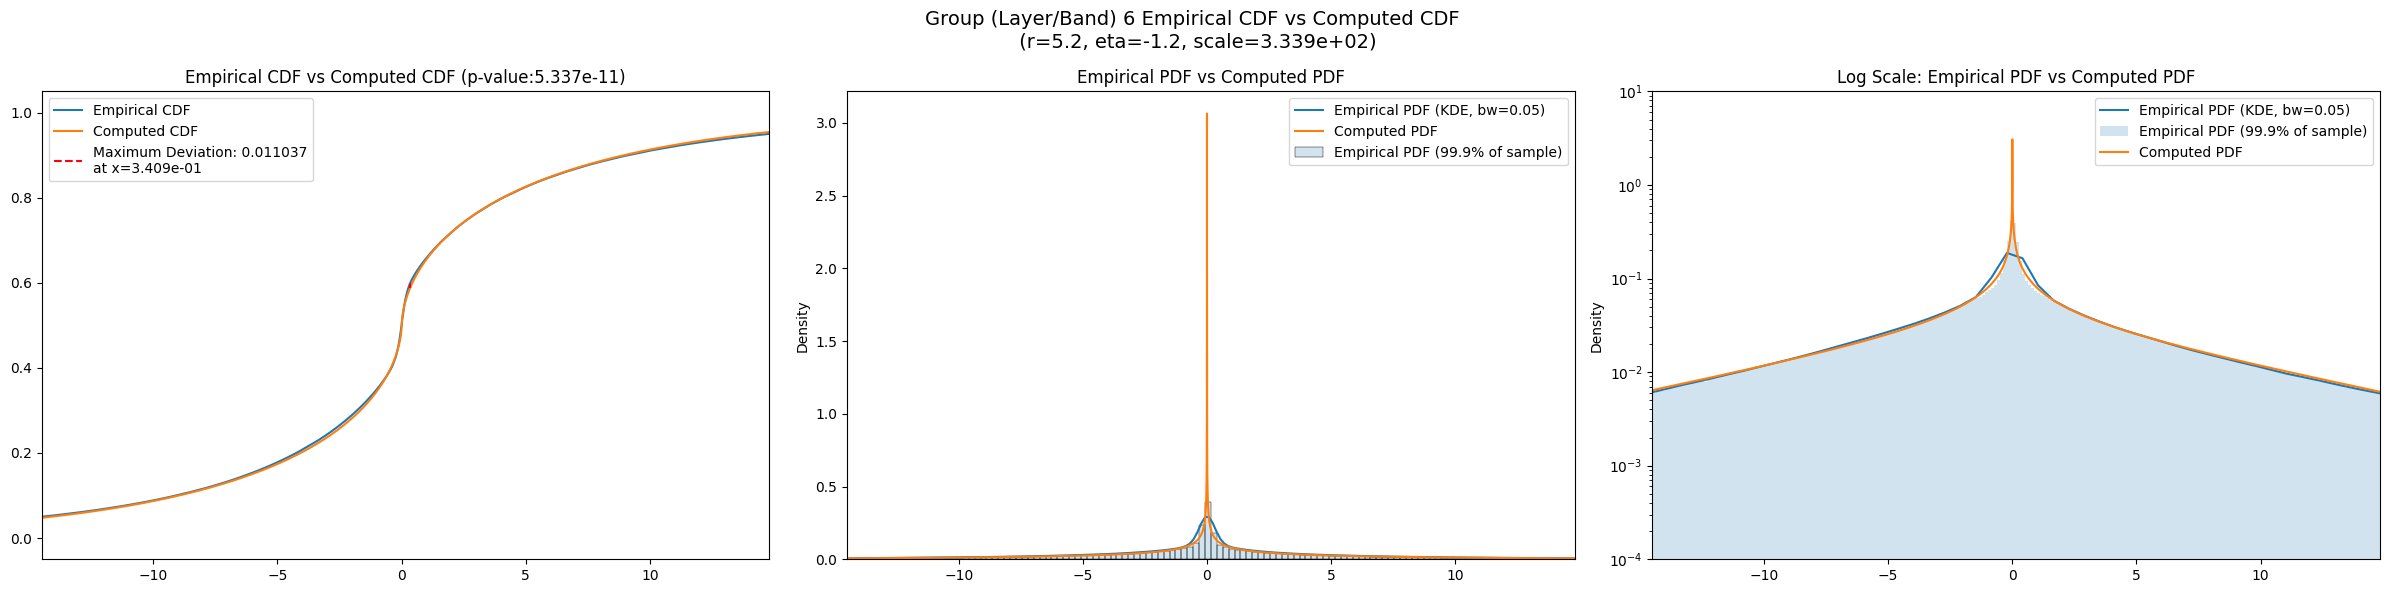

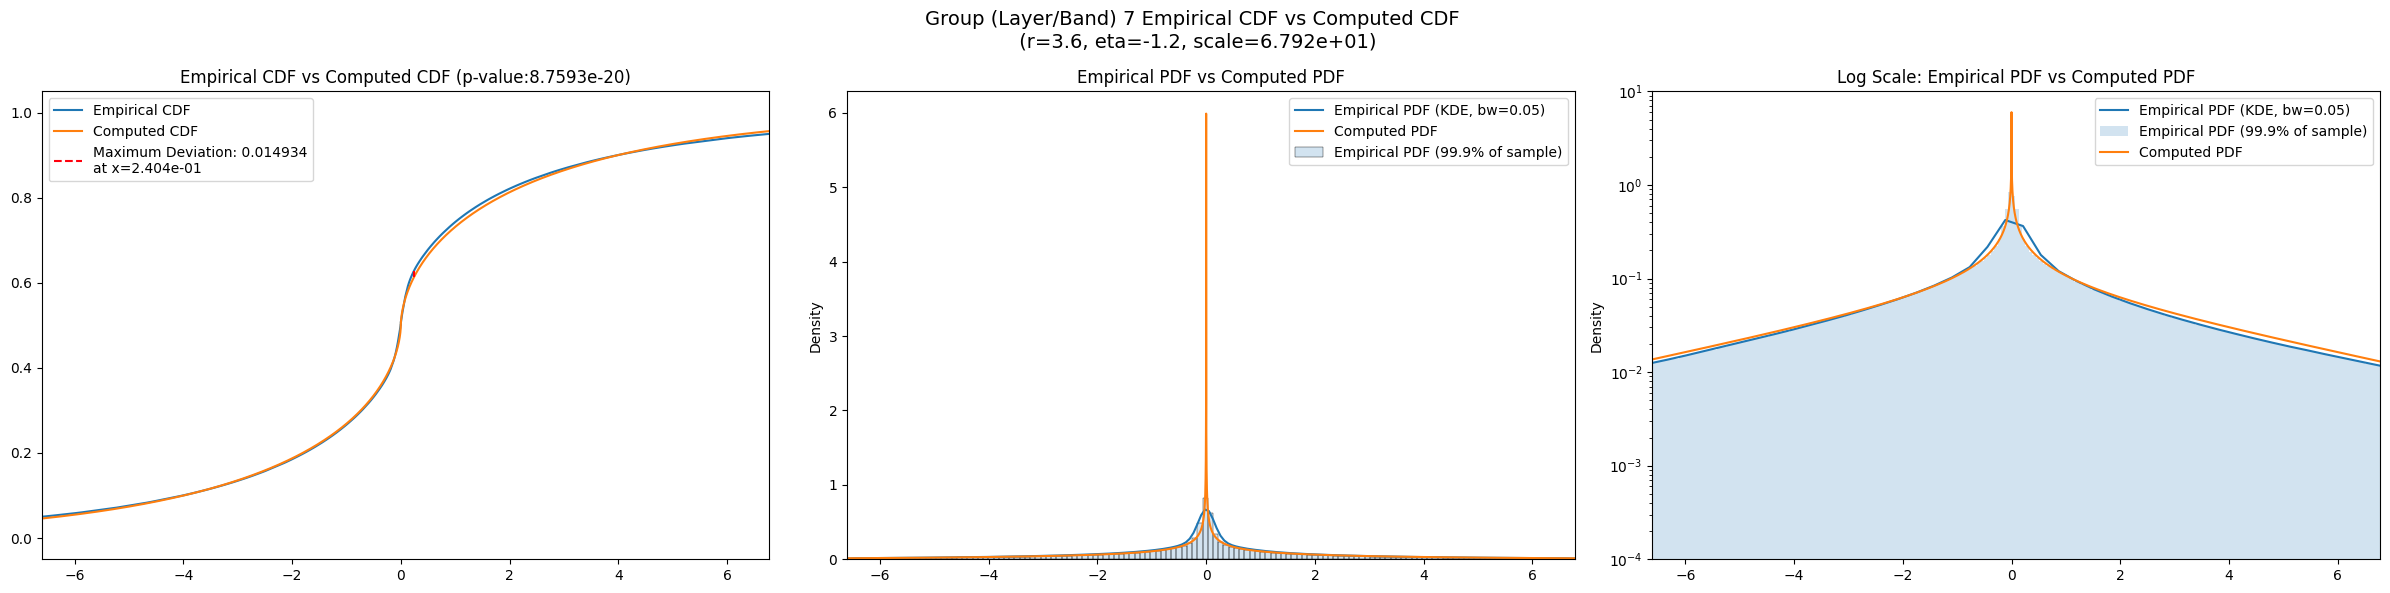

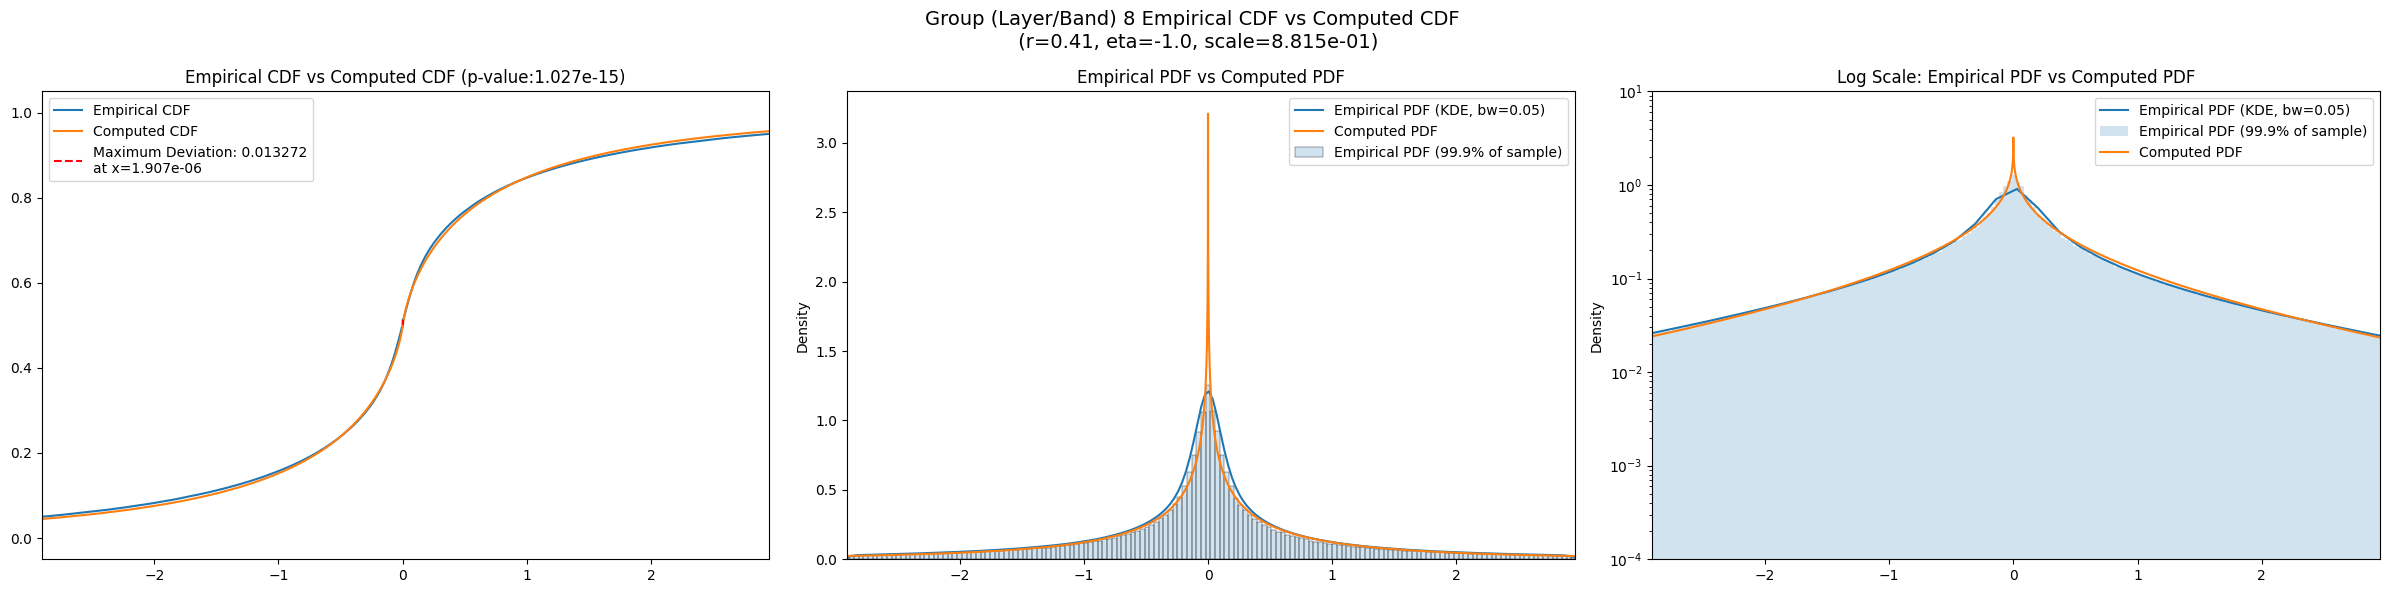

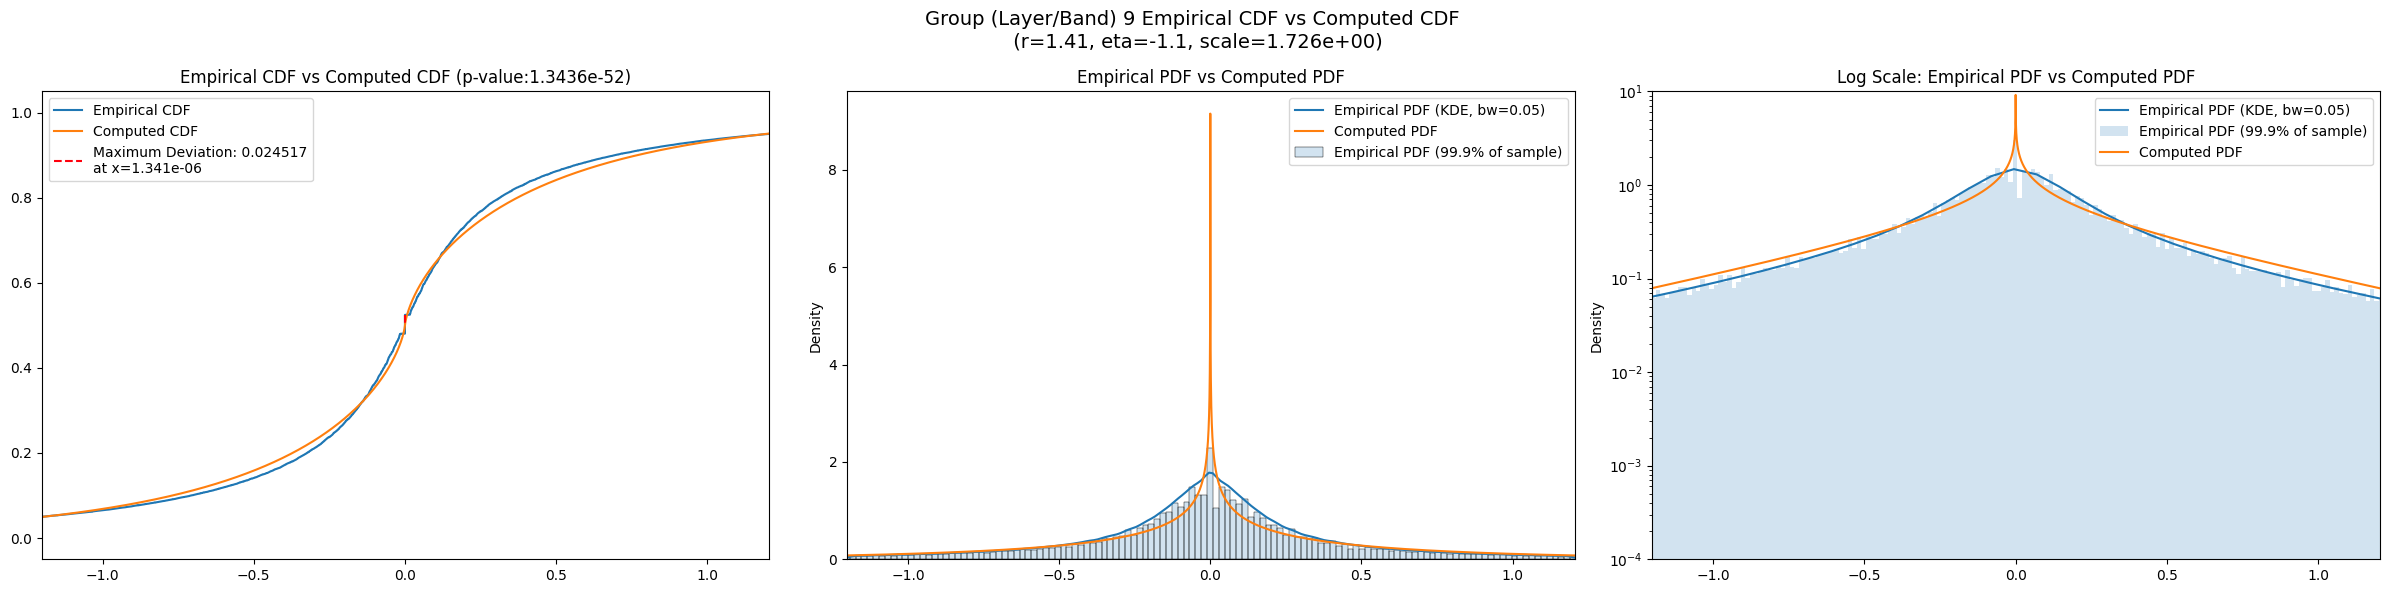

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,17165.852000,16108.495000,18292.553000,4.017385,2.713827,6.006314,27208.0,0.011858,5.1,-1.0,...,94.125800,0.044967,3.033620e-48,78.991400,0.025165,2.115600e-15,65.979900,0.031100,2.687470e-23,0.000943
3,4524.570000,4128.018600,4992.178700,11.562076,6.178833,24.957214,108832.0,0.131530,0.3,-1.3,...,20.946400,0.132334,0.000000e+00,14.361200,0.131540,0.000000e+00,11.459600,0.131540,0.000000e+00,0.000000
4,1373.499500,1260.057300,1500.444800,9.261635,6.085780,16.255730,333298.0,0.076360,0.6,-1.3,...,15.069000,0.102694,0.000000e+00,11.775100,0.088325,0.000000e+00,9.475180,0.091440,0.000000e+00,0.000000
5,373.972200,342.441220,410.995540,10.399797,6.170470,30.039886,1149538.0,0.040192,4.6,-1.3,...,8.650160,0.088447,0.000000e+00,6.880400,0.071859,0.000000e+00,5.505590,0.075162,0.000000e+00,0.000000
6,90.558690,82.759690,99.775560,11.086198,6.617087,28.133839,4251250.0,0.010945,5.2,-1.2,...,4.659030,0.075306,0.000000e+00,3.782200,0.055948,0.000000e+00,3.051940,0.060007,0.000000e+00,0.000000
7,20.864292,18.736567,23.678108,18.333368,9.082987,60.114044,17005000.0,0.014831,3.3,-1.2,...,1.955420,0.080614,0.000000e+00,1.620190,0.058797,0.000000e+00,1.289930,0.062423,0.000000e+00,0.000000
8,4.537877,3.986680,5.319919,28.597765,12.662612,99.220190,68020000.0,0.013255,0.4,-1.0,...,0.842763,0.077287,0.000000e+00,0.728513,0.051078,0.000000e+00,0.573774,0.052352,0.000000e+00,0.000000
9,0.850108,0.718232,1.177670,97.794940,14.378058,442.232270,272080000.0,0.024492,1.6,-1.1,...,0.428234,0.057947,0.000000e+00,0.376442,0.030833,0.000000e+00,0.298092,0.030237,0.000000e+00,0.000000


## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,0.011858,0.008227,0.011858,0.044967,0.025165,0.031100
3,0.131530,0.004115,0.131530,0.132334,0.131540,0.131540
4,0.076360,0.002352,0.076360,0.102694,0.088325,0.091440
5,0.040192,0.001267,0.040192,0.088447,0.071859,0.075162
6,0.010945,0.000659,0.010945,0.075306,0.055948,0.060007
7,0.014831,0.000329,0.014822,0.080614,0.058797,0.062423
8,0.013255,0.000165,0.013254,0.077287,0.051078,0.052352
9,0.024492,0.000082,0.024490,0.057947,0.030833,0.030237


In [20]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,17165.852000,0.011858,5.10,-1.0,54579.340804,0.0
3,4524.570000,0.131530,0.30,-1.3,1021.133528,0.0
4,1373.499500,0.076360,0.60,-1.3,3679.520769,0.0
5,300.903780,0.040192,4.60,-1.3,1950.127719,350.0
6,72.015950,0.010945,5.20,-1.2,333.905860,350.0
7,14.558240,0.014822,3.60,-1.2,67.919651,525.0
8,3.836597,0.013254,0.41,-1.0,0.881496,100.0
9,0.546290,0.024490,1.41,-1.1,1.726120,400.0


In [21]:
eng.quit()